In [1]:
import mne
import os
import numpy as np 
import argparse
from sklearn.utils import shuffle

mne.set_log_level('WARNING')

DATA_PATH="/srv/eeg_reconstruction/shared/biosemi-dataset"
LOW_FREQ = 0.1
HI_FREQ = 100
output_path = os.path.join(DATA_PATH, 'final_eeg2', str(LOW_FREQ).replace('.', '') + "_" + str(HI_FREQ))

seed = 20200220


In [2]:
input_file = "subj04_session2_eeg.fif"

# Load the BDF file
fif_file_path = os.path.join(DATA_PATH, 'fif', input_file) 
raw = mne.io.read_raw_fif(fif_file_path, preload=True)

In [17]:
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, tmin=-0.05, tmax=0.60, baseline=(None,0), preload=True)
epochs.drop_channels(['Status'])

<Epochs |  3840 events (all good), -0.0507812 – 0.599609 s, baseline -0.0507812 – 0 s, ~626.3 MB, data loaded,
 '1': 4
 '2': 4
 '3': 4
 '4': 4
 '5': 4
 '6': 4
 '7': 4
 '8': 4
 '9': 4
 '10': 4
 and 950 more events ...>

In [16]:
data = epochs.get_data(copy=True)
events = epochs.events[:,2]
img_cond = np.unique(events)
# del epochs
max_rep = 4


In [6]:
epoched_data = []
img_conditions = []

# Sorted data matrix of shape:
# Image conditions × EEG repetitions × EEG channels × EEG time points
sorted_data = np.zeros((len(img_cond),max_rep,data.shape[1], data.shape[2]))
for i in range(len(img_cond)):
    # Find the indices of the selected image condition
    idx = np.where(events == img_cond[i])[0]
    # Randomly select only the max number of EEG repetitions
    idx = shuffle(idx, random_state=seed, n_samples=max_rep)
    sorted_data[i] = data[idx]
del data
epoched_data.append(sorted_data[:, :, :, int(0.05*512):])
img_conditions.append(img_cond)
del sorted_data

In [7]:
epoched_data[0].shape

(960, 4, 64, 309)

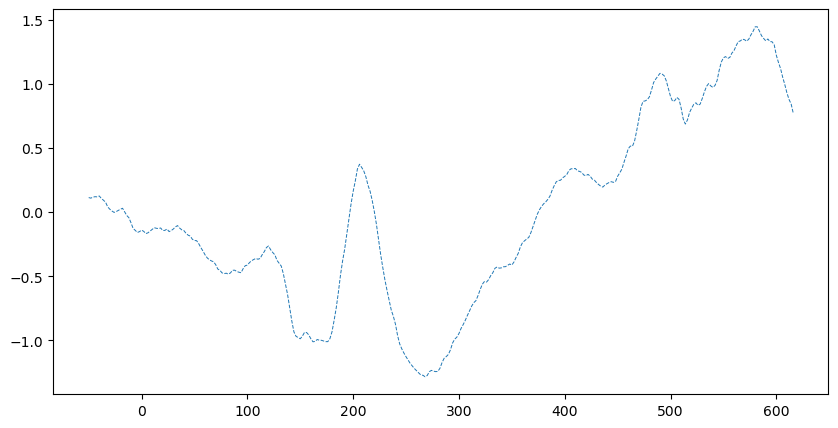

In [14]:
import matplotlib.pyplot as plt

def average_to_erp(epochs):
    '''
    Function to average epochs over occipital electrodes and return the ERP
    epochs: mne.Epochs

    '''
    # Subset occipital electrodes
    occ_elecs = [ch for ch in epochs.ch_names if ('o' in ch.lower() or 'p' in ch.lower()) and not 'c' in ch.lower()]
    occ_inds = [epochs.ch_names.index(elec) for elec in occ_elecs]

    # Averaging epochs over occipital electrodes
    elec_avg_epochs = mne.channels.combine_channels(epochs, {'occipital': [i for i in occ_inds]}, method = 'mean')
    

    # Average all epochs to get a single ERP
    erp = elec_avg_epochs.average()

    return erp


erp = average_to_erp(epochs)._data.squeeze() * 1e6
ticks = [i*2 - 50 for i in range(erp.shape[-1])]

plt.figure(figsize = (10,5))
plt.plot(ticks, erp, linestyle = '--', linewidth = 0.7)